<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一、持有A股流通市值" data-toc-modified-id="一、持有A股流通市值-1">一、持有A股流通市值</a></span></li><li><span><a href="#二、行业" data-toc-modified-id="二、行业-2">二、行业</a></span><ul class="toc-item"><li><span><a href="#1.前十大重仓股" data-toc-modified-id="1.前十大重仓股-2.1">1.前十大重仓股</a></span></li><li><span><a href="#2.行业持仓比例" data-toc-modified-id="2.行业持仓比例-2.2">2.行业持仓比例</a></span></li><li><span><a href="#3.超配比例" data-toc-modified-id="3.超配比例-2.3">3.超配比例</a></span></li></ul></li><li><span><a href="#三、风格结构" data-toc-modified-id="三、风格结构-3">三、风格结构</a></span></li></ul></div>

In [1]:
from it_data_tool.data_tool import *
from lowrisk_it_tools.WindPy import *
from macrotoolchain.mainAPI import *
di.display_html(getCatalogHtml(),raw=True)
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
di.HTML(getCatalogHtml())
h1Title('国家队投资行为')
h2Title('更新时间： {}年{}月{}日'.format(Date.today().year, Date.today().month, Date.today().day))

国家队投资行为

# 一、持有A股流通市值

计算方法：中国A股前十大流通股东中股东名称为国家队公司，持有数量\*当日收盘价；国家队公司为下图中除社保分类下的所有公司，社保与保险合并计算为险资
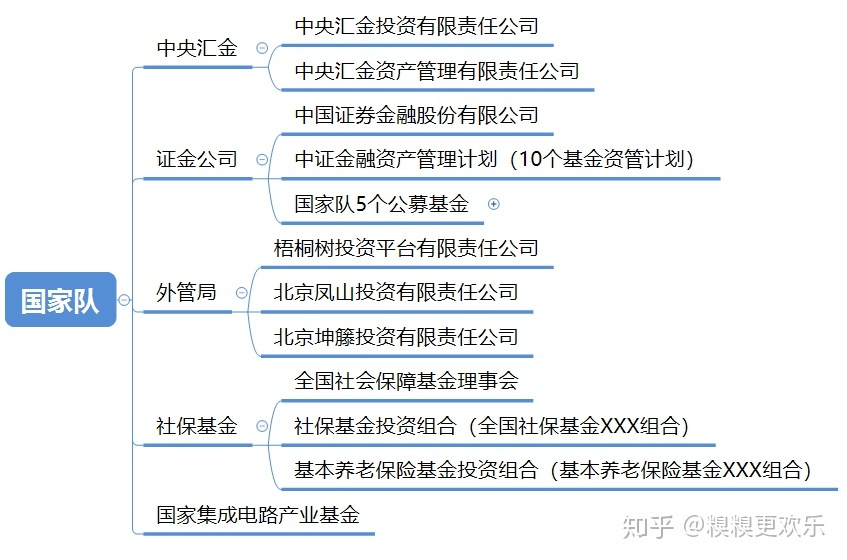
其中，中央汇金可以表示央行持股偏好，倾向持有大量银行股，不作为国家扶持行业的标准

In [2]:
# 所用日期序列
start_date = '20051231'
end_date = datetime.today().strftime('%Y%m%d')
date_list_base = pd.date_range(start_date,end_date,freq='Q')
date_list = [d.strftime('%Y%m%d') for d in date_list_base]

In [3]:
# A股流通市值
def cal_a_flow_nav():
    sql = '''
        select S_INFO_WINDCODE as scode, TRADE_DT, S_DQ_MV/1e4 as flow_market_value
        from ads_wind_AShareEODDerivativeIndicator_a
        where TRADE_DT in {}
        order by TRADE_DT, S_INFO_WINDCODE
        '''.format(tuple(date_list))
    df = get_quant_db_hz(sql).groupby(['trade_dt'])['flow_market_value'].sum()
    df.index = pd.to_datetime(df.index)
    return df

a_flow_nav = cal_a_flow_nav()

In [4]:
# 前10大流通股东，亿股
sql = '''
    select s_info_windcode as scode, s_holder_enddate as trade_dt, s_holder_holdercategory as type, s_holder_name as holder, s_holder_quantity/1e8 as shares
    from ads_wind_asharefloatholder_a
    where s_holder_enddate in {}
    order by s_holder_enddate,s_info_windcode
    '''.format(tuple(date_list))
float_holders = get_quant_db_hz(sql)

# A股收盘价
trade_date_list = w.tdays("2005-10-31", datetime.today().strftime('%Y%m%d'), "Period=Q",usedf=True)[1].index.tolist()
trade_date_list = [x.strftime('%Y%m%d') for x in trade_date_list]
sql = '''
    select S_INFO_WINDCODE as scode, TRADE_DT as old_dt, S_DQ_CLOSE as price
    from ads_wind_ashareeodprices_a
    where TRADE_DT in {}
    order by TRADE_DT, S_INFO_WINDCODE
    '''.format(tuple(trade_date_list))
astock_price = get_quant_db_hz(sql)
# 处理日期
date_df = pd.DataFrame(columns=['old_dt','trade_dt'])
if len(trade_date_list)!=len(date_list):
    trade_date_list = trade_date_list[:-1]
date_df['old_dt'] = trade_date_list
date_df['trade_dt'] = date_list
astock_price = pd.merge(astock_price,date_df,on=['old_dt']).drop(['old_dt'],axis=1)

In [5]:
gjd_list = ['中央汇金','汇金公司','中国证券金融','中证金融资产管理计划','易方达瑞惠','嘉实新机遇',
            '招商丰庆','南方消费活力','华夏新经济','梧桐树投资','凤山投资','国家集成电路产业投资基金']

def cal_gjd_nav():
    # 取出国家队
    rest_holders = float_holders[float_holders.type=='2'].copy()
    df = pd.DataFrame()
    for gjd in gjd_list:
        tmp = rest_holders[rest_holders.holder.str.contains(gjd)]
        df = pd.concat([df,tmp],axis=0)
    df = df.sort_values(['trade_dt','scode']).drop_duplicates()
    # 计算市值
    df = pd.merge(df,astock_price,on=['scode','trade_dt'])
    df['gjd_market_value'] = df['shares']*df['price']
    df.loc[(df.holder.str.contains('中央汇金')) | (df.holder.str.contains('汇金公司')),'bigtype'] = '中央汇金'
    df = df.fillna('狭义国家队')
    df1 = df.groupby(['trade_dt','bigtype'])['gjd_market_value'].sum().reset_index()
    df1 = df1.pivot_table(index=['trade_dt'],columns=['bigtype'],values=['gjd_market_value'])['gjd_market_value']
    df1.index = pd.to_datetime(df1.index)
    df.trade_dt = pd.to_datetime(df.trade_dt)
    return df,df1

gjd_specific,gjd_nav = cal_gjd_nav()

In [6]:
nav = pd.concat([gjd_nav,a_flow_nav],axis=1).dropna()
nav['gjd_market_value'] = nav['中央汇金']+nav['狭义国家队']
nav['bili'] = nav['gjd_market_value']/nav['flow_market_value']*100

In [7]:
from lowrisk.CustomECharts import *

s = Data(timeList=nav.index,dataList=nav['中央汇金'],title='中央汇金持有A股流通市值（亿元）')
bar_gra1 = barGraph(s,color='palevioletred',stack='1')
s = Data(timeList=nav.index,dataList=nav['狭义国家队'],title='狭义国家队持有A股流通市值（亿元）')
bar_gra2 = barGraph(s,color='lightskyblue',stack='1')
s = Data(timeList=nav.dropna().index,dataList=nav.dropna()['bili'],title='国家队持股总流通市值占A股总流通市值之比（%）')
line_gra = lineGraph(s,color='midnightblue',yAxisIndex=1)
plot_arr = [bar_gra1,bar_gra2,line_gra]

goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = [setAxis(),setAxis()],
                            title=setTitle("国家队持有A股流通市值"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

# 二、行业

由于中央汇金系持有大量金融股，此处去除中央汇金系，考察狭义国家队定义（即剩余持股股东）下的行业分布；由于2015年后开始救市，此处展示2015-09-30及之后的数据

## 1.前十大重仓股

计算方法：对于前十大流通股东中国家队持有的个股，找合计持股市值最大的前10只股票，作为持股金额

In [8]:
gjd_specific = gjd_specific[(gjd_specific.bigtype=='狭义国家队') & (gjd_specific.trade_dt>='2015-09-30')]
gjd_specific = gjd_specific.groupby(['trade_dt','scode'])['gjd_market_value'].sum().reset_index()

In [9]:
def cal_gjd_top10(df):
    df = df.copy()
    df = df.assign(rank = lambda x:x.groupby(['trade_dt'])['gjd_market_value'].rank(ascending=False,method='first'))
    df = df[df['rank']<=10]
    # 股票名称
    name_list = df.scode.drop_duplicates().tolist()
    sql = '''
        select s_info_windcode as scode, s_info_name as sname
        from ads_wind_asharedescription_a
        where s_info_windcode in {}
        '''.format(tuple(name_list))
    names = get_quant_db_hz(sql)
    # 已经是亿元单位了
    df = pd.merge(df,names,on=['scode']).sort_values(['trade_dt','rank'])
    return df

gjd_top10 = cal_gjd_top10(gjd_specific)

In [10]:
from lowrisk.CustomECharts import *
date_range = sorted(list(set(gjd_top10['trade_dt'].tolist())))
rank_range = sorted(list(set(gjd_top10['rank'].tolist())))
colors = ['crimson','darkorange','gold','mediumaquamarine','lightskyblue','dodgerblue','slateblue','violet','hotpink','mediumvioletred']
plot_arr = []
for i in range(len(rank_range)):
    r = rank_range[i]
    df = gjd_top10[gjd_top10['rank']==r].sort_values(['trade_dt'])
    s = Data(timeList=df.trade_dt.tolist(),dataList=df.gjd_market_value.tolist(),title='top{}'.format(i+1))
    bar_gra = barGraph(s,color=colors[i],label={'position':'insideTop',
                                                'show': True,
                                                'rotate':60,
                                                'formatter':'{@[2]}',
                                                'align':'left',
                                                'verticalAlign':'middle'
                                               })
    for i in range(len(bar_gra['data'])):
        bar_gra['data'][i].append(df.sname.tolist()[i])
    plot_arr.append(bar_gra)

goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                            yAxis = setAxis(),
                            title=setTitle("国家队季度前十大重仓股持有总市值（亿元）"),
                            legend=dict(
                                        x="center",
                                        y="bottom",
                                        orient='horizontal',
                                        padding=[0,50,0,0]
                                        ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )

## 2.行业持仓比例

计算方法：根据每季度持股市值，加总求得每个行业的季度市值，计算整体占比

In [11]:
sql = '''
    select wind_code as scode, citic_industry as industry
    from ads_wind_ahshareciticsindustries_style_a
    '''
ind = get_quant_db_hz(sql)
gjd_specific = pd.merge(gjd_specific,ind,on=['scode'],how='left')
gjd_specific['industry'] = gjd_specific['industry'].fillna('综合')
gjd_specific.trade_dt = pd.to_datetime(gjd_specific.trade_dt)
# 行业和中信一级行业对齐
gjd_specific.loc[gjd_specific.industry=='保险Ⅱ','industry'] = '非银行金融'
gjd_specific.loc[gjd_specific.industry=='证券Ⅱ','industry'] = '非银行金融'
gjd_specific.loc[gjd_specific.industry=='多元金融','industry'] = '非银行金融'
gjd_specific.loc[gjd_specific.industry=='酒类','industry'] = '食品饮料'
gjd_specific.loc[gjd_specific.industry=='食品','industry'] = '食品饮料'
gjd_specific.loc[gjd_specific.industry=='饮料','industry'] = '食品饮料'

In [12]:
def cal_gjd_indratio(df):
    df = df.copy()
    df = df.groupby(['trade_dt','industry'])['gjd_market_value'].sum().reset_index()
    df = df.assign(tot_guimo = lambda x:x.groupby(['trade_dt'])['gjd_market_value'].transform('sum'),
                  w = lambda x:x['gjd_market_value']/x['tot_guimo'])
    df = df[['trade_dt','industry','w']].pivot_table(index=['trade_dt'],columns=['industry'],values=['w'])['w']
    df = df*100
    return df

gjd_indratio = cal_gjd_indratio(gjd_specific)

In [13]:
bankuai = {'上游周期':['石油石化','基础化工','煤炭','钢铁','有色金属','建筑','建材','农林牧渔'],
           '中游制造':['电力及公用事业','电力设备及新能源','汽车','机械','交通运输','轻工制造','国防军工'],
           '大消费':['商贸零售','食品饮料','纺织服装','家电','消费者服务','医药'],
           'TMT':['电子','计算机','通信','传媒'],
           '金融地产':['银行','非银行金融','房地产','综合金融'],
           '其他':['综合']}
dabankuai = ['上游周期','中游制造','大消费','TMT','金融地产','其他']

In [14]:
def draw(name):
    df = gjd_indratio[bankuai[name]].copy()
    plot_arr = []
    for i in range(len(df.columns)):
        column = df.columns[i]
        color = colors[i]
        s = Data(timeList=df.index,dataList=df[column].tolist(),title=column)
        line_gra = lineGraph(s,color=color)
        plot_arr.append(line_gra)
    g = goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                                    yAxis = setAxis(),
                                    title=setTitle("国家队{}板块季度持仓比例（%）".format(name)),
                                    legend=dict(
                                                x="center",
                                                y="bottom",
                                                orient='horizontal',
                                                padding=[0,50,0,0]
                                                ),
                                    grid=[{
                                            "left":"5%",
                                            "right":"10%",
                                            "height":"70%"
                                        }],
                                    dataZoom=[
                                                {
                                                    "type":"slider",
                                                    "xAxisIndex":0,
                                                    "f'selector':TrueilterMode":'empty',
                                                    "bottom":"8%"
                                                },
                                                {
                                                    "type":"slider",
                                                    "yAxisIndex":0,
                                                    "filterMode":'empty'
                                                },
                                            ]
                                   )
                )
    return g

graphs = []
for name in dabankuai:
    graphs.append(draw(name))

In [15]:
graphs[0]

In [16]:
graphs[1]

In [17]:
graphs[2]

In [18]:
graphs[3]

In [19]:
graphs[4]

In [20]:
graphs[5]

## 3.超配比例

计算方法：计算各个行业在A股自由流通市值中的比例，再计算各个行业在国家队持仓中的比例，计算两者之差

In [21]:
def get_ashares_nav(sd,ed):
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select s_info_windcode as scode, trade_dt as ann_date, s_dq_mv as nav
        from ads_wind_ashareeodderivativeindicator_a
        where trade_dt in {}
        '''.format(tuple(date_list))
    df = get_quant_db_hz(sql)
    sql = '''
        select wind_code as scode, citic_industry as industry
        from ads_wind_ahshareciticsindustries_style_a
        '''
    ind = get_quant_db_hz(sql)
    df = pd.merge(df,ind,on=['scode'],how='left')
    df['industry'] = df['industry'].fillna('综合')
    df.ann_date = pd.to_datetime(df.ann_date)
    df = df.dropna()
    # 行业和中信一级行业对齐
    df.loc[df.industry=='保险Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='证券Ⅱ','industry'] = '非银行金融'
    df.loc[df.industry=='多元金融','industry'] = '非银行金融'
    df.loc[df.industry=='酒类','industry'] = '食品饮料'
    df.loc[df.industry=='食品','industry'] = '食品饮料'
    df.loc[df.industry=='饮料','industry'] = '食品饮料'
    return df
ashares_nav = get_ashares_nav(start_date,end_date)

In [22]:
def cal_gjd_excess(df1,df2):
    ashares_nav_tot = df1.groupby(['ann_date','industry'])['nav'].sum().reset_index().sort_values(['ann_date'])
    ashares_nav_tot['nav'] /= 1e8
    ashares_nav_tot = ashares_nav_tot.assign(tot = lambda x:x.groupby(['ann_date'])['nav'].transform('sum'),
                                             nav = lambda x:x['nav']/x['tot']*100)
    df2 = df2.stack().reset_index().rename(columns={0:'w','trade_dt':'ann_date'})
    # Ashares多的是周末
    df = pd.merge(ashares_nav_tot,df2,on=['ann_date','industry'])
    df['excess'] = df['w'] - df['nav']
    df = df[['ann_date','industry','excess']].pivot_table(index=['ann_date'],columns=['industry'],values=['excess'])['excess']
    return df

gjd_excess = cal_gjd_excess(ashares_nav,gjd_indratio)

In [23]:
def draw(name):
    df = gjd_excess[bankuai[name]].copy()
    plot_arr = []
    for i in range(len(df.columns)):
        column = df.columns[i]
        color = colors[i]
        s = Data(timeList=df.index,dataList=df[column].tolist(),title=column)
        line_gra = lineGraph(s,color=color)
        plot_arr.append(line_gra)
    g = goechart(plot_arr,setLayout(xAxis = setAxis(type="time"),
                                    yAxis = setAxis(),
                                    title=setTitle("国家队{}板块日度超配比例（%）".format(name)),
                                    legend=dict(
                                                x="center",
                                                y="bottom",
                                                orient='horizontal',
                                                padding=[0,50,0,0]
                                                ),
                                    grid=[{
                                            "left":"5%",
                                            "right":"10%",
                                            "height":"70%"
                                        }],
                                    dataZoom=[
                                                {
                                                    "type":"slider",
                                                    "xAxisIndex":0,
                                                    "f'selector':TrueilterMode":'empty',
                                                    "bottom":"8%"
                                                },
                                                {
                                                    "type":"slider",
                                                    "yAxisIndex":0,
                                                    "filterMode":'empty'
                                                },
                                            ]
                                   )
                )
    return g

graphs = []
for name in dabankuai:
    graphs.append(draw(name))

In [24]:
graphs[0]

In [25]:
graphs[1]

In [26]:
graphs[2]

In [27]:
graphs[4]

In [28]:
graphs[5]

# 三、风格结构

计算方法：计算国家队所有股票按照市值加权的PE、PB

In [29]:
def get_pepb(df,sd,ed):
    stock_list = list(set(df.scode.tolist()))
    date_list = pd.date_range(sd,ed,freq='Q')
    date_list = [x.strftime('%Y%m%d') for x in date_list]
    sql = '''
        select s_info_windcode as scode,trade_dt as trade_dt,s_val_pe_ttm as pe,s_val_pb_new as pb
        from ads_wind_ashareeodderivativeindicator_a
        where s_info_windcode in {} and trade_dt in {}
        '''.format(tuple(stock_list),tuple(date_list))
    df1 = get_quant_db_hz(sql)
    sql = '''
        select s_info_windcode as scode,financial_trade_dt as trade_dt,s_val_pe_ttm as pe,s_val_pb_new as pb
        from ads_wind_hkshareeodderivativeindex_a
        where s_info_windcode in {} and financial_trade_dt in {}
        '''.format(tuple(stock_list),tuple(date_list))
    df2 = get_quant_db_hz(sql)
    df = pd.concat([df1,df2],axis=0)
    df.trade_dt = pd.to_datetime(df.trade_dt)
    return df

pepb = get_pepb(gjd_specific,start_date,end_date)

In [30]:
def cal_gjd_pepb(df,tmp):
    df = df.copy()
    df = df.groupby(['trade_dt','scode'])['gjd_market_value'].sum().reset_index()
    df = df.assign(tot_nav = lambda x:x.groupby(['trade_dt'])['gjd_market_value'].transform('sum'),
                  guimo = lambda x:x['gjd_market_value']/x['tot_nav'])
    df = df.drop(['tot_nav'],axis=1)
    df = pd.merge(df,tmp,on=['scode','trade_dt'])
    df['pe'] *= df['guimo']
    df['pb'] *= df['guimo']
    df = df.groupby(['trade_dt'])[['pe','pb']].sum().reset_index()
    return df

gjd_pepb = cal_gjd_pepb(gjd_specific,pepb)

In [31]:
from lowrisk.CustomECharts import *
s = Data(timeList=gjd_pepb.trade_dt.tolist(),dataList=gjd_pepb['pe'].tolist(),title='PE')
line_gra1 = lineGraph(s,color='midnightblue')
s = Data(timeList=gjd_pepb.trade_dt.tolist(),dataList=gjd_pepb['pb'].tolist(),title='PB')
line_gra2 = lineGraph(s,color='palevioletred',yAxisIndex=1)
plot_arr = [line_gra1,line_gra2]

goechart(plot_arr,
         setLayout(xAxis = setAxis(type="time"),
                   yAxis=[
                            setAxis(title='PE'),
                            setAxis(title='PB',range=[0,20])
                         ],
                   title=setTitle("国家队持仓市值加权估值"),
                   legend=dict(
                                x="center",
                                y="bottom",
                                orient='horizontal',
                                padding=[0,50,0,0]
                                ),
                            grid=[{
                                    "left":"5%",
                                    "right":"10%",
                                    "height":"70%"
                                }],
                            dataZoom=[
                                        {
                                            "type":"slider",
                                            "xAxisIndex":0,
                                            "f'selector':TrueilterMode":'empty',
                                            "bottom":"8%"
                                        },
                                        {
                                            "type":"slider",
                                            "yAxisIndex":0,
                                            "filterMode":'empty'
                                        },
                                    ]
                           )
        )